# Import MNIST dataset

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

# data key containing an array with one row per instance and column per feature
# DESCR key describes the dataset
# target key containing an array with the labels

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [2]:
X, y = mnist["data"], mnist["target"]
X.shape
# 70,000 28x28 images

(70000, 784)

In [3]:
y.shape

(70000,)

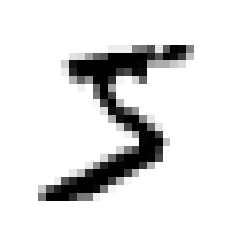

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [5]:
y[0]

'5'

In [6]:
# Cast y to integers
import numpy as np

y = y.astype(np.uint8)

In [7]:
# Create test and train set. Train (first 60,000) and test (10,000)
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Training a Binary Classifier
Goal: Create a number 5-detector
<br>
classes: 5, not-5

In [8]:
y_train_5 = (y_train == 5) # True for all 5s
y_test_5 = (y_test == 5)

In [9]:
# Train a stochasitic gradient descent classifier
# Can handle very large datasets efficiently
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [10]:
sgd_clf.predict([some_digit])

array([ True])

### Performance Measures
1. Cross Validation

In [11]:
# StratifiedKFold performs stratified sampling to produce folds that contain a
# representative ratio of each class.
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

def custom_cross_val( xtrain, ytrain_5, classifier ):
  skfolds = StratifiedKFold(n_splits=3, random_state=42)
  result = []

  for train_index, test_index in skfolds.split(xtrain, ytrain_5):
    clone_clf = clone(classifier) # create a clone of the classifier
    xtrain_folds = xtrain[train_index]
    ytrain_5_folds = ytrain_5[train_index]
    xtest_folds = xtrain[test_index]
    ytest_folds = ytrain_5[test_index]

    clone_clf.fit(xtrain_folds, ytrain_5_folds) # train clone on the training folds
    y_pred = clone_clf.predict(xtest_folds) # make predictions
    n_correct = sum(y_pred == ytest_folds) # count number of correct predictions
    result.append(n_correct / len(y_pred))  # append ratio of correct predictions
  return result

In [12]:
custom_cross_val(X_train, y_train_5, sgd_clf)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


[0.95035, 0.96035, 0.9604]

In [13]:
# using sklearn's implementation
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [14]:
# Naive classifier for not-5 class
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
  def fit(self, X, y=None):
    pass
  def predict(self, X):
    return np.zeros((len(X), 1), dtype=bool)

In [15]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

#### 2. Confusion Matrix

In [16]:
from sklearn.model_selection import cross_val_predict # returns predictions on each test fold

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [17]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

Precision = (TP) / (TP + FP)<br>
Recall = (TP) / (TP + FN)

In [18]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [19]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

F<sub>1</sub> score is the harmonic mean of the precision and recall<br>
F<sub>1</sub> score = (TP) / (TP + ((FN + FP) /2))

In [20]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

### Precision/Recall Tradeoff
Deciding the best threshold

In [21]:
# Get decision scores
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [22]:
# compute precision and recall for all possible thresholds
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [23]:
def plot_precision_recall_vs_threshold(precision, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
  plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
  # highlight the threshold, add the legend, axis label and grid
  plt.legend(loc="center right", fontsize=16) 
  plt.xlabel("Threshold", fontsize=16)        
  plt.grid(True)                              
  plt.axis([-50000, 50000, 0, 1])  

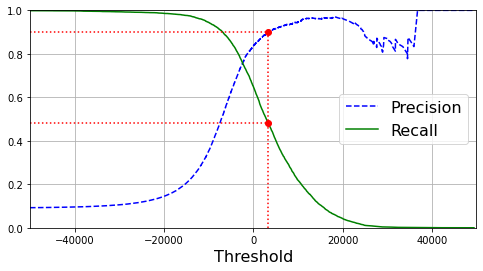

In [24]:
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")                                             
plt.plot([threshold_90_precision], [recall_90_precision], "ro") 
plt.show()

In [25]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

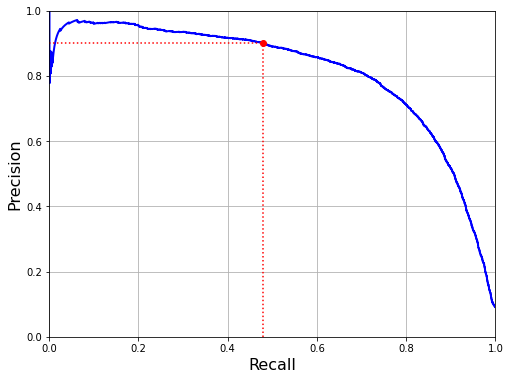

In [26]:
plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
plt.show()

In [27]:
# Suppose we aim for 90% precision
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [28]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [29]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

### Receiver Operating Curve (ROC Curve)

In [30]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [31]:
def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0,1], [0,1], 'k--') # dashed diagonal
  plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16)
  plt.ylabel('True Positive Rate (Recall)', fontsize=16)
  plt.grid(True)

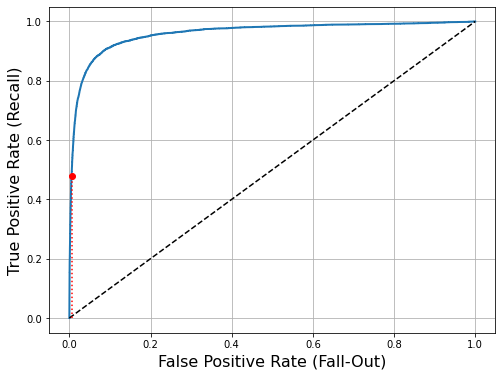

In [32]:
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.show()

In [33]:
# get area under the curve (AUC)
from sklearn.metrics import  roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [34]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [35]:
# Use positive class's probability as the score
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, threshold_forest = roc_curve(y_train_5, y_scores_forest)

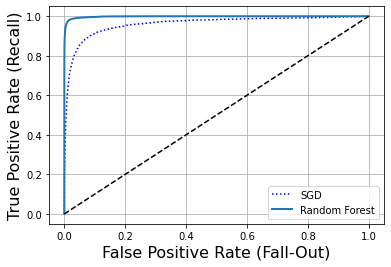

In [36]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [37]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [38]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)

In [39]:
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [40]:
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

### Multilabel classification

In [43]:
sgd_v2 = SGDClassifier(random_state=42)
sgd_v2.fit(X_train, y_train)
sgd_v2.predict([some_digit])

array([3], dtype=uint8)

In [44]:
some_digit_scores = sgd_v2.decision_function([some_digit])
some_digit_scores

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [45]:
np.argmax(some_digit_scores)

3

In [46]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5], dtype=uint8)

In [47]:
len(ovo_clf.estimators_)

45

In [48]:
forest_v2 = RandomForestClassifier(random_state=42)
forest_v2.fit(X_train, y_train)
forest_v2.predict([some_digit])

array([5], dtype=uint8)

In [49]:
forest_v2.predict_proba([some_digit])

array([[0.  , 0.  , 0.01, 0.08, 0.  , 0.9 , 0.  , 0.  , 0.  , 0.01]])

In [50]:
cross_val_score(sgd_v2, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [51]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_v2, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

In [52]:
y_train_pred = cross_val_predict(sgd_v2, X_train_scaled, y_train, cv=3)
confusion_matrix = confusion_matrix(y_train, y_train_pred)
confusion_matrix

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

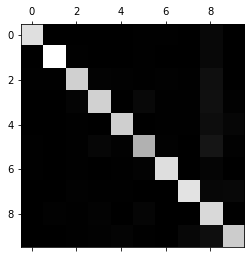

In [57]:
plt.matshow(confusion_matrix, cmap=plt.cm.gray)
plt.show()

In [58]:
row_sums = confusion_matrix.sum(axis=1, keepdims=True)
norm_confusion_matrix = confusion_matrix / row_sums

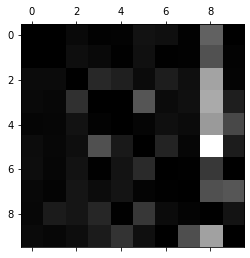

In [59]:
np.fill_diagonal(norm_confusion_matrix, 0)
plt.matshow(norm_confusion_matrix, cmap=plt.cm.gray)
plt.show()

### Multilabel Classification

In [60]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [61]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [62]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

### Multioutput Classification
The generalization of multilabel classification where each label can e multiclass(i.e. it can have more than two possible values)

In [64]:
# Add noise to the data
# Target will be the original data
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

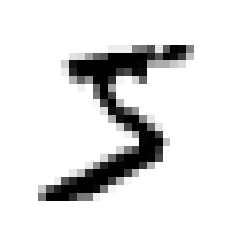

In [66]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[0]])
clean_digit_image = some_digit.reshape(28, 28)

plt.imshow(clean_digit_image, cmap = mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

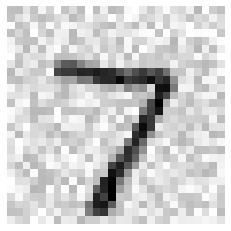

In [68]:
index_image = X_test_mod[0]
clean_index_image = index_image.reshape(28, 28)
plt.imshow(clean_index_image, cmap=mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()